In [1]:
import pandas as pd
import numpy as np
import librosa
import glob
from natsort import natsorted
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten,Dense, Dropout,GlobalAveragePooling2D,BatchNormalization, Add,Input, Activation)
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical
import seaborn as sns
import random

/Users/kishi/Documents/ローカルコード/★データ分析/【練習問題】音楽ラベリング/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# メタデータの読み込み
train_master = pd.read_csv('train_master.csv', index_col=0) 
label_master = pd.read_csv('label_master.csv')
sample_submit = pd.read_csv('sample_submit.csv', header=None)

label_list = label_master.to_dict()['label_name']
print("ラベル:", label_list)
print("訓練データ数:", len(train_master))

ラベル: {0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
訓練データ数: 500


In [3]:
# データ拡張関数の定義
def add_white_noise(audio, noise_factor=0.005):
    """ホワイトノイズを追加"""
    noise = np.random.randn(len(audio))
    augmented_audio = audio + noise_factor * noise
    return augmented_audio

def time_shift(audio, shift_max=0.2):
    """時間軸方向のシフト"""
    shift = int(np.random.uniform(-shift_max, shift_max) *
len(audio))
    if shift > 0:
        augmented_audio = np.r_[audio[shift:], np.zeros(shift)]
    else:
        augmented_audio = np.r_[np.zeros(-shift), audio[:shift]]
    return augmented_audio

def time_stretch(audio, rate=None):
    """時間ストレッチ（速度変更）"""
    if rate is None:
        rate = np.random.uniform(0.8, 1.2)  # 0.8倍から1.2倍の速度
    augmented_audio = librosa.effects.time_stretch(audio, rate=rate)
    return augmented_audio

def extract_mfcc_from_audio(audio, sr, n_mfcc=13, max_len=130):
    """音声データからMFCCを抽出"""
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)

    # 固定長にパディング/トリミング
    if mfccs.shape[1] < max_len:
        pad_width = max_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, ((0, 0), (0, pad_width)),
mode='constant')
    else:
        mfccs = mfccs[:, :max_len]

    return mfccs

print("データ拡張関数を定義しました。")

データ拡張関数を定義しました。


In [4]:
# 拡張された訓練データのMFCC特徴量を抽出
def extract_mfcc(file_path, n_mfcc=13, max_len=130):
    """MFCCを抽出し、固定長にする"""
    try:
        y, sr = librosa.load(file_path)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

        # 固定長にパディング/トリミング
        if mfccs.shape[1] < max_len:
            pad_width = max_len - mfccs.shape[1]
            mfccs = np.pad(mfccs, ((0, 0), (0, pad_width)),
mode='constant')
        else:
            mfccs = mfccs[:, :max_len]

        return mfccs
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# 拡張された訓練データの作成
train_files = natsorted(glob.glob('train_sound*/train_*.au'))
print(f"元の訓練ファイル数: {len(train_files)}")

X_train_augmented = []
y_train_augmented = []

for i, file_path in enumerate(train_files):
    if i % 50 == 0:
        print(f"処理中: {i}/{len(train_files)}")

    try:
        # 元の音声データを読み込み
        y, sr = librosa.load(file_path)
        file_index = int(file_path.split('_')[-1].split('.')[0])
        label = train_master.iloc[file_index]['label_id']

        # 1. 元のデータ
        mfccs_original = extract_mfcc_from_audio(y, sr)
        if mfccs_original is not None:
            X_train_augmented.append(mfccs_original)
            y_train_augmented.append(label)

        # 2. ホワイトノイズを追加
        y_noise = add_white_noise(y)
        mfccs_noise = extract_mfcc_from_audio(y_noise, sr)
        if mfccs_noise is not None:
            X_train_augmented.append(mfccs_noise)
            y_train_augmented.append(label)

        # 3. 時間シフト
        y_shift = time_shift(y)
        mfccs_shift = extract_mfcc_from_audio(y_shift, sr)
        if mfccs_shift is not None:
            X_train_augmented.append(mfccs_shift)
            y_train_augmented.append(label)

        # 4. 時間ストレッチ
        y_stretch = time_stretch(y)
        mfccs_stretch = extract_mfcc_from_audio(y_stretch, sr)
        if mfccs_stretch is not None:
            X_train_augmented.append(mfccs_stretch)
            y_train_augmented.append(label)

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        continue

X_train = np.array(X_train_augmented)
y_train = np.array(y_train_augmented)

print(f"拡張後の訓練データ形状: {X_train.shape}")
print(f"拡張後のラベル形状: {y_train.shape}")
print(f"データ拡張率: {len(y_train_augmented) / len(train_files):.1f}倍")

元の訓練ファイル数: 500
処理中: 0/500
処理中: 50/500
処理中: 100/500
処理中: 150/500
処理中: 200/500
処理中: 250/500
処理中: 300/500
処理中: 350/500
処理中: 400/500
処理中: 450/500
拡張後の訓練データ形状: (2000, 13, 130)
拡張後のラベル形状: (2000,)
データ拡張率: 4.0倍


In [5]:
# テストデータのMFCC特徴量を抽出
test_files = natsorted(glob.glob('test_sound*/test_*.au'))
print(f"テストファイル数: {len(test_files)}")

X_test = []

for i, file_path in enumerate(test_files):
    if i % 50 == 0:
        print(f"処理中: {i}/{len(test_files)}")

    mfccs = extract_mfcc(file_path)
    if mfccs is not None:
        X_test.append(mfccs)

X_test = np.array(X_test)
print(f"テストデータ形状: {X_test.shape}")

テストファイル数: 500
処理中: 0/500
処理中: 50/500
処理中: 100/500
処理中: 150/500
処理中: 200/500
処理中: 250/500
処理中: 300/500
処理中: 350/500
処理中: 400/500
処理中: 450/500
テストデータ形状: (500, 13, 130)


In [7]:
# データの前処理（ResNet用の3チャンネル入力）
def create_3channel_input(mfcc_data):
    """MFCCを3チャンネルに変換してResNetに適合させる"""
    # MFCCデータを3つの異なる方法で表現
    channel1 = mfcc_data  # 元のMFCC
    channel2 = np.gradient(mfcc_data, axis=1)  # 時間方向の勾配（delta）
    channel3 = np.gradient(channel2, axis=1)  # delta-delta

    # 3チャンネルを結合
    three_channel = np.stack([channel1, channel2, channel3], axis=-1)
    return three_channel

# ResNet用の前処理
print("ResNet用のデータ前処理を開始...")

# 3チャンネル変換
X_train_3channel = np.array([create_3channel_input(x) for x in X_train])
X_test_3channel = np.array([create_3channel_input(x) for x in X_test])

# データ正規化（ResNetには重要）
X_train_3channel = (X_train_3channel - np.mean(X_train_3channel)) /np.std(X_train_3channel)
X_test_3channel = (X_test_3channel - np.mean(X_test_3channel)) /np.std(X_test_3channel)

# ラベルをone-hot encodingに変換
y_train_categorical = to_categorical(y_train, num_classes=10)

# 訓練データを訓練用と検証用に分割
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_3channel, y_train_categorical, test_size=0.2,random_state=42, stratify=y_train)

print(f"ResNet用訓練データ形状: {X_train_split.shape}")
print(f"ResNet用検証データ形状: {X_val_split.shape}")
print(f"ResNet用テストデータ形状: {X_test_3channel.shape}")
print(f"チャンネル数: {X_train_split.shape[-1]}")

# データの範囲確認
print(f"データ範囲: [{np.min(X_train_split):.3f}, {np.max(X_train_split):.3f}]")

ResNet用のデータ前処理を開始...
ResNet用訓練データ形状: (1600, 13, 130, 3)
ResNet用検証データ形状: (400, 13, 130, 3)
ResNet用テストデータ形状: (500, 13, 130, 3)
チャンネル数: 3
データ範囲: [-17.430, 6.337]


In [8]:
# ResNet18風アーキテクチャの構築（音声データ用カスタム版）
def residual_block(x, filters, kernel_size=3, stride=1, 
conv_shortcut=False):
    """ResNetの残差ブロック"""
    if conv_shortcut:
        shortcut = Conv2D(filters, 1, strides=stride,padding='same')(x)
        shortcut = BatchNormalization()(shortcut)
    else:
        shortcut = x

    x = Conv2D(filters, kernel_size, strides=stride,padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    return x

def build_resnet18_audio(input_shape=(13, 130, 3), num_classes=10):
    """音声データ用にカスタマイズされたResNet18風モデル"""
    inputs = Input(shape=input_shape)

    # Initial convolution
    x = Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(3, strides=2, padding='same')(x)

    # ResNet blocks
    # Block 1
    x = residual_block(x, 64)
    x = residual_block(x, 64)

    # Block 2
    x = residual_block(x, 128, stride=2, conv_shortcut=True)
    x = residual_block(x, 128)

    # Block 3
    x = residual_block(x, 256, stride=2, conv_shortcut=True)
    x = residual_block(x, 256)

    # Block 4
    x = residual_block(x, 512, stride=2, conv_shortcut=True)
    x = residual_block(x, 512)

    # Global average pooling and classification
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# ResNet18風モデルの作成
print("ResNet18風モデルを構築中...")
resnet_model = build_resnet18_audio(input_shape=(13, 130, 3),num_classes=10)

# モデルのコンパイル
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001, weight_decay=1e-4)

resnet_model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

# モデルの構造を表示
resnet_model.summary()
print(f"\\n総パラメータ数: {resnet_model.count_params():,}")

# モデル可視化（オプション）
try:
    tf.keras.utils.plot_model(resnet_model,to_file='resnet18_audio_model.png',show_shapes=True,how_layer_names=True)
    print("モデル図をresnet18_audio_model.pngに保存しました")
except:
    print("モデル可視化をスキップしました")

ResNet18風モデルを構築中...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13, 130,   │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 7, 65, 64) │      9,472 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 7, 65, 64) │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 7, 65, 64) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 4, 33, 64) │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 4, 33, 64) │     36,928 │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 33, 64) │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 4, 33, 64) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 4, 33, 64) │     36,928 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 33, 64) │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 4, 33, 64) │          0 │ max_pooling2d[0]… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 4, 33, 64) │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 4, 33, 64) │     36,928 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 33, 64) │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 4, 33, 64) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 4, 33, 64) │     36,928 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 33, 64) │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 4, 33, 64) │          0 │ activation_2[0][… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 11,356,426 (43.32 MB)

 Trainable params: 11,346,826 (43.28 MB)

 Non-trainable params: 9,600 (37.50 KB)

\n総パラメータ数: 11,356,426
You must install pydot (`pip install pydot`) for `plot_model` to work.
モデル図をresnet18_audio_model.pngに保存しました


In [10]:
# ResNet18風モデルの訓練（高度な学習スケジューリング）
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os

# コールバックの設定（より厳密な条件）
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=7,
    min_lr=1e-6,
    verbose=1
)

# ベストモデルの保存
checkpoint = ModelCheckpoint(
    'best_resnet18_audio_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

# コサイン減衰学習率スケジューラ
def cosine_decay_with_warmup(epoch, lr):
    warmup_epochs = 5
    total_epochs = 80

    if epoch < warmup_epochs:
        return lr * (epoch + 1) / warmup_epochs
    else:
        return 0.001 * 0.5 * (1 + np.cos(np.pi * (epoch -warmup_epochs) / (total_epochs - warmup_epochs)))

cosine_scheduler =tf.keras.callbacks.LearningRateScheduler(cosine_decay_with_warmup,verbose=1)

print("ResNet18風モデルの訓練を開始...")
print(f"訓練データ: {len(X_train_split)} サンプル")
print(f"検証データ: {len(X_val_split)} サンプル")
print(f"バッチサイズ: 32")
print(f"最大エポック数: 80")

# モデルの訓練
history = resnet_model.fit(X_train_split, y_train_split,
    batch_size=32,  # ResNetでは小さめのバッチサイズが効果的
    epochs=80,
    validation_data=(X_val_split, y_val_split),
    callbacks=[early_stopping, reduce_lr, checkpoint,cosine_scheduler],
    verbose=1
)

print(f"\\nResNet18訓練完了!")
print(f"最終エポック: {len(history.history['loss'])}")

# 最終検証精度
final_val_loss, final_val_accuracy = resnet_model.evaluate(X_val_split, y_val_split, verbose=0)
print(f"最終検証精度: {final_val_accuracy:.4f}")
print(f"最終検証損失: {final_val_loss:.4f}")

ResNet18風モデルの訓練を開始...
訓練データ: 1600 サンプル
検証データ: 400 サンプル
バッチサイズ: 32
最大エポック数: 80

Epoch 1: LearningRateScheduler setting learning rate to 0.00020000000949949026.
Epoch 1/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.1787 - loss: 2.5001
Epoch 1: val_accuracy improved from -inf to 0.10000, saving model to best_resnet18_audio_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 141ms/step - accuracy: 0.1798 - loss: 2.4959 - val_accuracy: 0.1000 - val_loss: 2.3004 - learning_rate: 2.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 8.000000379979611e-05.
Epoch 2/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.3400 - loss: 1.8681
Epoch 2: val_accuracy did not improve from 0.10000
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.3402 - loss: 1.8681 - val_accuracy: 0.1000 - val_loss: 2.3200 - learning_rate: 8.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 4.800000315299258e-05.
Epoch 3/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.3848 - loss: 1.6798
Epoch 3: val_accuracy improved from 0.10000 to 0.18250, saving model to best_resnet18_audio_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.3853 - loss: 1.6793 - val_accuracy: 0.1825 - val_loss: 2.3699 - learning_rate: 4.8000e-05

Epoch 4: LearningRateScheduler setting learning rate to 3.840000135824084e-05.
Epoch 4/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.4687 - loss: 1.5313
Epoch 4: val_accuracy did not improve from 0.18250
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.4688 - loss: 1.5312 - val_accuracy: 0.1450 - val_loss: 2.4333 - learning_rate: 3.8400e-05

Epoch 5: LearningRateScheduler setting learning rate to 3.840000135824084e-05.
Epoch 5/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.5073 - loss: 1.4347
Epoch 5: val_accuracy did not improve from 0.18250
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 0.5072 - loss: 1.4345 - val_accuracy: 0.1725 - val_loss: 2.5049 - learning_rate: 3.8400e-05

Epoch 6: LearningRateScheduler setting learning rate to 0.001.
Epoch 6/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.3

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.3111 - loss: 1.9894 - val_accuracy: 0.2725 - val_loss: 3.2134 - learning_rate: 9.9956e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0009982464296247522.
Epoch 8/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.3898 - loss: 1.7746
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.00029947394505143167.

Epoch 8: val_accuracy did not improve from 0.27250
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.3897 - loss: 1.7749 - val_accuracy: 0.2075 - val_loss: 4.2153 - learning_rate: 2.9947e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.000996057350657239.
Epoch 9/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.3821 - loss: 1.6815
Epoch 9: val_accuracy improved from 0.27250 to 0.38000, saving model to best_resnet18_audio_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 0.3817 - loss: 1.6825 - val_accuracy: 0.3800 - val_loss: 2.0987 - learning_rate: 9.9606e-04

Epoch 10: LearningRateScheduler setting learning rate to 0.0009929980185352525.
Epoch 10/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.3927 - loss: 1.7360
Epoch 10: val_accuracy did not improve from 0.38000
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 0.3928 - loss: 1.7355 - val_accuracy: 0.2775 - val_loss: 2.2143 - learning_rate: 9.9300e-04

Epoch 11: LearningRateScheduler setting learning rate to 0.0009890738003669028.
Epoch 11/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.4367 - loss: 1.6312
Epoch 11: val_accuracy did not improve from 0.38000
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 0.4364 - loss: 1.6316 - val_accuracy: 0.3225 - val_loss: 2.2509 - learning_rate: 9.8907e-04

Epoch 12: LearningRateScheduler setting learning rate to 0.0009842915805643156.
Epoch 12/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 13

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.4783 - loss: 1.4792 - val_accuracy: 0.4325 - val_loss: 1.6805 - learning_rate: 9.7866e-04

Epoch 14: LearningRateScheduler setting learning rate to 0.0009721881851187407.
Epoch 14/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.4809 - loss: 1.5072
Epoch 14: val_accuracy did not improve from 0.43250
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 0.4812 - loss: 1.5067 - val_accuracy: 0.3725 - val_loss: 1.8191 - learning_rate: 9.7219e-04

Epoch 15: LearningRateScheduler setting learning rate to 0.0009648882429441257.
Epoch 15/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.5545 - loss: 1.3638
Epoch 15: val_accuracy improved from 0.43250 to 0.44500, saving model to best_resnet18_audio_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.5541 - loss: 1.3645 - val_accuracy: 0.4450 - val_loss: 1.4941 - learning_rate: 9.6489e-04

Epoch 16: LearningRateScheduler setting learning rate to 0.0009567727288213005.
Epoch 16/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.5387 - loss: 1.3846
Epoch 16: val_accuracy did not improve from 0.44500
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 0.5383 - loss: 1.3853 - val_accuracy: 0.3650 - val_loss: 2.0621 - learning_rate: 9.5677e-04

Epoch 17: LearningRateScheduler setting learning rate to 0.0009478558801197064.
Epoch 17/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.5440 - loss: 1.3474
Epoch 17: val_accuracy did not improve from 0.44500
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 0.5439 - loss: 1.3476 - val_accuracy: 0.4200 - val_loss: 1.6230 - learning_rate: 9.4786e-04

Epoch 18: LearningRateScheduler setting learning rate to 0.0009381533400219318.
Epoch 18/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 13

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 0.5902 - loss: 1.1983 - val_accuracy: 0.4600 - val_loss: 1.5636 - learning_rate: 9.2768e-04

Epoch 20: LearningRateScheduler setting learning rate to 0.0009164606203550497.
Epoch 20/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.6072 - loss: 1.1966
Epoch 20: val_accuracy improved from 0.46000 to 0.53000, saving model to best_resnet18_audio_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 0.6071 - loss: 1.1966 - val_accuracy: 0.5300 - val_loss: 1.4391 - learning_rate: 9.1646e-04

Epoch 21: LearningRateScheduler setting learning rate to 0.0009045084971874737.
Epoch 21/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.6135 - loss: 1.1562
Epoch 21: val_accuracy improved from 0.53000 to 0.57750, saving model to best_resnet18_audio_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.6137 - loss: 1.1554 - val_accuracy: 0.5775 - val_loss: 1.1441 - learning_rate: 9.0451e-04

Epoch 22: LearningRateScheduler setting learning rate to 0.0008918467286629199.
Epoch 22/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.6662 - loss: 1.0231
Epoch 22: val_accuracy did not improve from 0.57750
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.6662 - loss: 1.0226 - val_accuracy: 0.4525 - val_loss: 1.6860 - learning_rate: 8.9185e-04

Epoch 23: LearningRateScheduler setting learning rate to 0.0008784975278258782.
Epoch 23/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.6590 - loss: 1.0181
Epoch 23: val_accuracy improved from 0.57750 to 0.58500, saving model to best_resnet18_audio_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.6591 - loss: 1.0175 - val_accuracy: 0.5850 - val_loss: 1.4400 - learning_rate: 8.7850e-04

Epoch 24: LearningRateScheduler setting learning rate to 0.0008644843137107057.
Epoch 24/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.6930 - loss: 0.9565
Epoch 24: val_accuracy did not improve from 0.58500
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.6925 - loss: 0.9575 - val_accuracy: 0.5200 - val_loss: 1.4493 - learning_rate: 8.6448e-04

Epoch 25: LearningRateScheduler setting learning rate to 0.0008498316702566828.
Epoch 25/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.6918 - loss: 0.9797
Epoch 25: val_accuracy did not improve from 0.58500
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step - accuracy: 0.6914 - loss: 0.9810 - val_accuracy: 0.5525 - val_loss: 1.5321 - learning_rate: 8.4983e-04

Epoch 26: LearningRateScheduler setting learning rate to 0.0008345653031794292.
Epoch 26/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 14

50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step - accuracy: 0.7824 - loss: 0.6923 - val_accuracy: 0.6575 - val_loss: 1.0031 - learning_rate: 8.1871e-04

Epoch 28: LearningRateScheduler setting learning rate to 0.0008022995574311875.
Epoch 28/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.7846 - loss: 0.6958
Epoch 28: val_accuracy improved from 0.65750 to 0.66750, saving model to best_resnet18_audio_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 155ms/step - accuracy: 0.7843 - loss: 0.6970 - val_accuracy: 0.6675 - val_loss: 1.1489 - learning_rate: 8.0230e-04

Epoch 29: LearningRateScheduler setting learning rate to 0.000785356783842216.
Epoch 29/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.7837 - loss: 0.7195
Epoch 29: val_accuracy improved from 0.66750 to 0.69750, saving model to best_resnet18_audio_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - accuracy: 0.7836 - loss: 0.7196 - val_accuracy: 0.6975 - val_loss: 1.0357 - learning_rate: 7.8536e-04

Epoch 30: LearningRateScheduler setting learning rate to 0.0007679133974894983.
Epoch 30/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.7894 - loss: 0.6864
Epoch 30: val_accuracy did not improve from 0.69750
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 165ms/step - accuracy: 0.7894 - loss: 0.6858 - val_accuracy: 0.6625 - val_loss: 1.2482 - learning_rate: 7.6791e-04

Epoch 31: LearningRateScheduler setting learning rate to 0.00075.
Epoch 31/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.8220 - loss: 0.5740
Epoch 31: val_accuracy did not improve from 0.69750
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 170ms/step - accuracy: 0.8218 - loss: 0.5743 - val_accuracy: 0.6600 - val_loss: 1.1692 - learning_rate: 7.5000e-04

Epoch 32: LearningRateScheduler setting learning rate to 0.0007316480175599309.
Epoch 32/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - acc

50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step - accuracy: 0.8354 - loss: 0.5776 - val_accuracy: 0.7200 - val_loss: 0.9230 - learning_rate: 7.1289e-04

Epoch 34: LearningRateScheduler setting learning rate to 0.0006937577932260515.
Epoch 34/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.8398 - loss: 0.5216
Epoch 34: val_accuracy did not improve from 0.72000
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 170ms/step - accuracy: 0.8396 - loss: 0.5219 - val_accuracy: 0.5525 - val_loss: 1.6124 - learning_rate: 6.9376e-04

Epoch 35: LearningRateScheduler setting learning rate to 0.0006742860236609076.
Epoch 35/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.8197 - loss: 0.6482
Epoch 35: val_accuracy did not improve from 0.72000
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 173ms/step - accuracy: 0.8199 - loss: 0.6469 - val_accuracy: 0.6625 - val_loss: 1.3256 - learning_rate: 6.7429e-04

Epoch 36: LearningRateScheduler setting learning rate to 0.0006545084971874737.
Epoch 36/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16

50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 173ms/step - accuracy: 0.8766 - loss: 0.4260 - val_accuracy: 0.7400 - val_loss: 0.8836 - learning_rate: 6.5451e-04

Epoch 37: LearningRateScheduler setting learning rate to 0.0006344599103076329.
Epoch 37/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.8586 - loss: 0.4279
Epoch 37: val_accuracy did not improve from 0.74000
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 170ms/step - accuracy: 0.8587 - loss: 0.4280 - val_accuracy: 0.6250 - val_loss: 1.6064 - learning_rate: 6.3446e-04

Epoch 38: LearningRateScheduler setting learning rate to 0.0006141754350553279.
Epoch 38/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.8707 - loss: 0.4435
Epoch 38: val_accuracy did not improve from 0.74000
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 170ms/step - accuracy: 0.8705 - loss: 0.4438 - val_accuracy: 0.6525 - val_loss: 1.2329 - learning_rate: 6.1418e-04

Epoch 39: LearningRateScheduler setting learning rate to 0.0005936906572928624.
Epoch 39/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16

50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 174ms/step - accuracy: 0.8959 - loss: 0.3234 - val_accuracy: 0.7450 - val_loss: 0.8523 - learning_rate: 5.7304e-04

Epoch 41: LearningRateScheduler setting learning rate to 0.0005522642316338269.
Epoch 41/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.8985 - loss: 0.3297
Epoch 41: val_accuracy improved from 0.74500 to 0.79250, saving model to best_resnet18_audio_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step - accuracy: 0.8983 - loss: 0.3302 - val_accuracy: 0.7925 - val_loss: 0.7586 - learning_rate: 5.5226e-04

Epoch 42: LearningRateScheduler setting learning rate to 0.0005313952597646568.
Epoch 42/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.8925 - loss: 0.3137
Epoch 42: val_accuracy did not improve from 0.79250
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 163ms/step - accuracy: 0.8924 - loss: 0.3138 - val_accuracy: 0.7325 - val_loss: 1.2009 - learning_rate: 5.3140e-04

Epoch 43: LearningRateScheduler setting learning rate to 0.0005104712099416785.
Epoch 43/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9239 - loss: 0.2342
Epoch 43: val_accuracy did not improve from 0.79250
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 164ms/step - accuracy: 0.9237 - loss: 0.2349 - val_accuracy: 0.7425 - val_loss: 0.9573 - learning_rate: 5.1047e-04

Epoch 44: LearningRateScheduler setting learning rate to 0.0004895287900583216.
Epoch 44/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 15

50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 170ms/step - accuracy: 0.9269 - loss: 0.2301 - val_accuracy: 0.8025 - val_loss: 0.8318 - learning_rate: 8.0506e-05

Epoch 56: LearningRateScheduler setting learning rate to 0.0002499999999999999.
Epoch 56/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.9471 - loss: 0.1794
Epoch 56: val_accuracy did not improve from 0.80250
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 168ms/step - accuracy: 0.9471 - loss: 0.1794 - val_accuracy: 0.8025 - val_loss: 0.7400 - learning_rate: 2.5000e-04

Epoch 57: LearningRateScheduler setting learning rate to 0.00023208660251050178.
Epoch 57/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9398 - loss: 0.1777
Epoch 57: val_accuracy did not improve from 0.80250
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 170ms/step - accuracy: 0.9396 - loss: 0.1781 - val_accuracy: 0.7725 - val_loss: 0.9146 - learning_rate: 2.3209e-04

Epoch 58: LearningRateScheduler setting learning rate to 0.0002146432161577842.
Epoch 58/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1

50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 174ms/step - accuracy: 0.9389 - loss: 0.1731 - val_accuracy: 0.8100 - val_loss: 0.7338 - learning_rate: 2.1464e-04

Epoch 59: LearningRateScheduler setting learning rate to 0.00019770044256881258.
Epoch 59/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9453 - loss: 0.1606
Epoch 59: val_accuracy improved from 0.81000 to 0.81250, saving model to best_resnet18_audio_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 178ms/step - accuracy: 0.9451 - loss: 0.1608 - val_accuracy: 0.8125 - val_loss: 0.7461 - learning_rate: 1.9770e-04

Epoch 60: LearningRateScheduler setting learning rate to 0.00018128800512565513.
Epoch 60/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.9398 - loss: 0.1692
Epoch 60: val_accuracy did not improve from 0.81250
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step - accuracy: 0.9398 - loss: 0.1692 - val_accuracy: 0.8050 - val_loss: 0.7616 - learning_rate: 1.8129e-04

Epoch 61: LearningRateScheduler setting learning rate to 0.0001654346968205709.
Epoch 61/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9422 - loss: 0.1602
Epoch 61: val_accuracy did not improve from 0.81250
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 171ms/step - accuracy: 0.9422 - loss: 0.1602 - val_accuracy: 0.8050 - val_loss: 0.7711 - learning_rate: 1.6543e-04

Epoch 62: LearningRateScheduler setting learning rate to 0.00015016832974331724.
Epoch 62/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 

50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 172ms/step - accuracy: 0.9425 - loss: 0.1708 - val_accuracy: 0.8175 - val_loss: 0.7181 - learning_rate: 1.5017e-04

Epoch 63: LearningRateScheduler setting learning rate to 0.00013551568628929433.
Epoch 63/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.9487 - loss: 0.1397
Epoch 63: val_accuracy did not improve from 0.81750
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 182ms/step - accuracy: 0.9486 - loss: 0.1399 - val_accuracy: 0.8150 - val_loss: 0.7272 - learning_rate: 1.3552e-04

Epoch 64: LearningRateScheduler setting learning rate to 0.00012150247217412185.
Epoch 64/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.9437 - loss: 0.1498
Epoch 64: val_accuracy did not improve from 0.81750
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 178ms/step - accuracy: 0.9437 - loss: 0.1498 - val_accuracy: 0.8150 - val_loss: 0.7384 - learning_rate: 1.2150e-04

Epoch 65: LearningRateScheduler setting learning rate to 0.00010815327133708014.
Epoch 65/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s

50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 186ms/step - accuracy: 0.9492 - loss: 0.1356 - val_accuracy: 0.8225 - val_loss: 0.7778 - learning_rate: 7.2318e-05

Epoch 69: LearningRateScheduler setting learning rate to 6.184665997806821e-05.
Epoch 69/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.9336 - loss: 0.1769
Epoch 69: ReduceLROnPlateau reducing learning rate to 1.8553997506387532e-05.

Epoch 69: val_accuracy improved from 0.82250 to 0.82500, saving model to best_resnet18_audio_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 180ms/step - accuracy: 0.9338 - loss: 0.1764 - val_accuracy: 0.8250 - val_loss: 0.7556 - learning_rate: 1.8554e-05

Epoch 70: LearningRateScheduler setting learning rate to 5.214411988029366e-05.
Epoch 70/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.9378 - loss: 0.1717
Epoch 70: val_accuracy improved from 0.82500 to 0.82750, saving model to best_resnet18_audio_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 183ms/step - accuracy: 0.9380 - loss: 0.1713 - val_accuracy: 0.8275 - val_loss: 0.7490 - learning_rate: 5.2144e-05

Epoch 71: LearningRateScheduler setting learning rate to 4.3227271178699624e-05.
Epoch 71/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.9525 - loss: 0.1422
Epoch 71: val_accuracy did not improve from 0.82750
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 178ms/step - accuracy: 0.9524 - loss: 0.1423 - val_accuracy: 0.8225 - val_loss: 0.7949 - learning_rate: 4.3227e-05

Epoch 72: LearningRateScheduler setting learning rate to 3.5111757055874326e-05.
Epoch 72/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9590 - loss: 0.1287
Epoch 72: val_accuracy did not improve from 0.82750
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 178ms/step - accuracy: 0.9588 - loss: 0.1290 - val_accuracy: 0.8250 - val_loss: 0.7934 - learning_rate: 3.5112e-05

Epoch 73: LearningRateScheduler setting learning rate to 2.78118148812595e-05.
Epoch 73/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1

50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 182ms/step - accuracy: 0.9478 - loss: 0.1581 - val_accuracy: 0.8300 - val_loss: 0.7497 - learning_rate: 1.5708e-05

Epoch 76: LearningRateScheduler setting learning rate to 1.0926199633097212e-05.
Epoch 76/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9472 - loss: 0.1359
Epoch 76: ReduceLROnPlateau reducing learning rate to 3.2778600143501533e-06.

Epoch 76: val_accuracy did not improve from 0.83000
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 177ms/step - accuracy: 0.9472 - loss: 0.1360 - val_accuracy: 0.8300 - val_loss: 0.7541 - learning_rate: 3.2779e-06

Epoch 77: LearningRateScheduler setting learning rate to 7.001981464747509e-06.
Epoch 77/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.9578 - loss: 0.1452
Epoch 77: val_accuracy did not improve from 0.83000
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 183ms/step - accuracy: 0.9577 - loss: 0.1453 - val_accuracy: 0.8275 - val_loss: 0.7540 - learning_rate: 7.0020e-06

Epoch 78: LearningRateScheduler setting lear

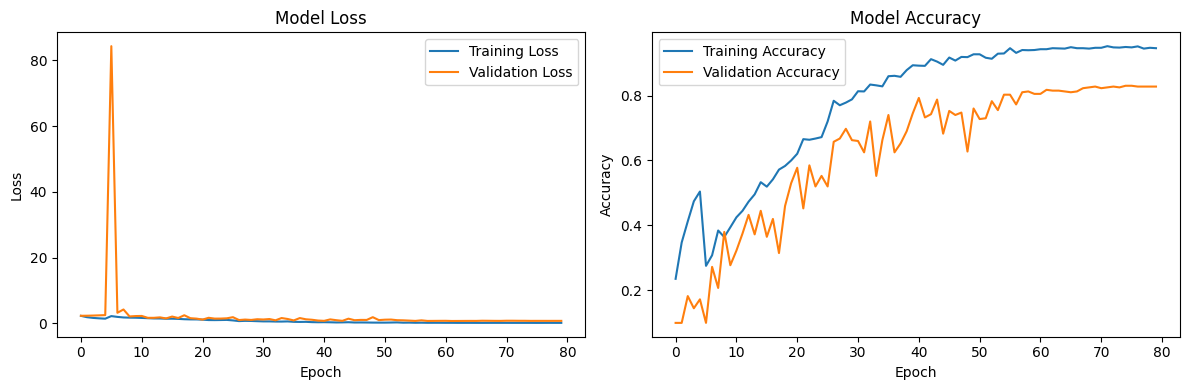

検証精度: 0.8300


In [13]:
# 訓練履歴の可視化
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# 最終的な検証精度
val_loss, val_accuracy = resnet_model.evaluate(X_val_split, y_val_split, verbose=0)
print(f"検証精度: {val_accuracy:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
分類レポート:
              precision    recall  f1-score   support

       blues       0.86      0.78      0.82        40
   classical       0.93      0.95      0.94        40
     country       0.71      0.75      0.73        40
       disco       0.85      0.70      0.77        40
      hiphop       0.76      0.88      0.81        40
        jazz       0.92      0.82      0.87        40
       metal       0.82      0.90      0.86        40
         pop       1.00      0.82      0.90        40
      reggae       0.79      0.85      0.82        40
        rock       0.74      0.85      0.79        40

    accuracy                           0.83       400
   macro avg       0.84      0.83      0.83       400
weighted avg       0.84      0.83      0.83       400



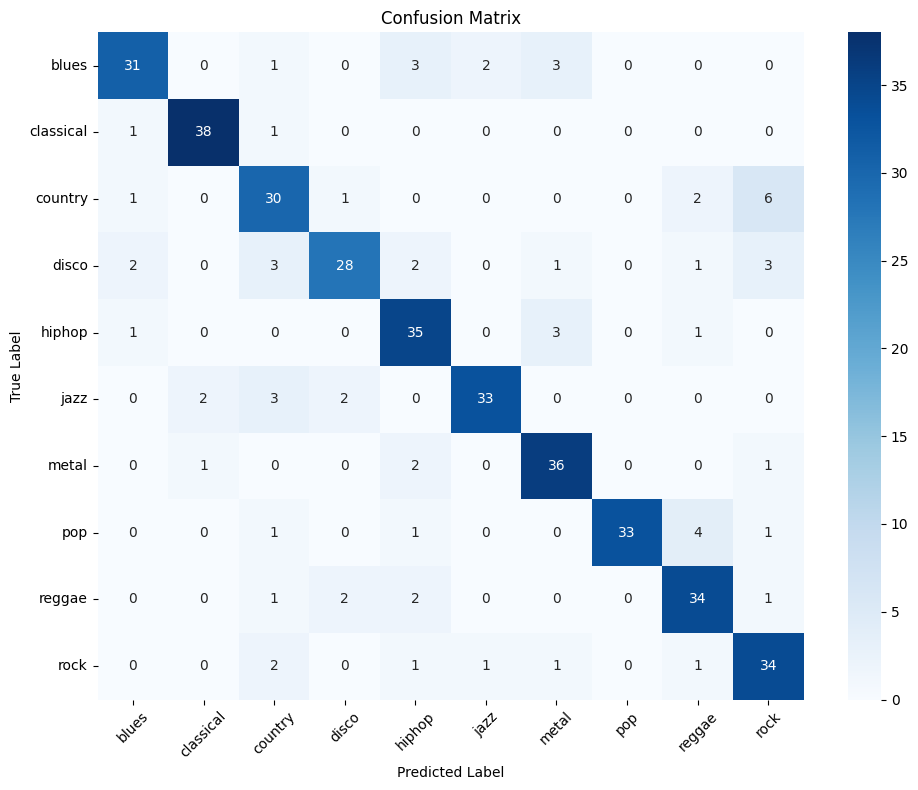

In [15]:
# 詳細な評価
y_pred = resnet_model.predict(X_val_split)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val_split, axis=1)

# 分類レポート
print("分類レポート:")
print(classification_report(y_true_classes, y_pred_classes, target_names=[label_list[i] for i in range(10)]))

# 混同行列
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[label_list[i] for i in range(10)], yticklabels=[label_list[i] for i in range(10)])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

ResNet18モデルでテストデータを予測中...
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/var/folders/d8/wkw09mvn41qb7dmtkv41txt40000gn/T/ipykernel_50315/438142672.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(max_probs, labels=['Confidence'])


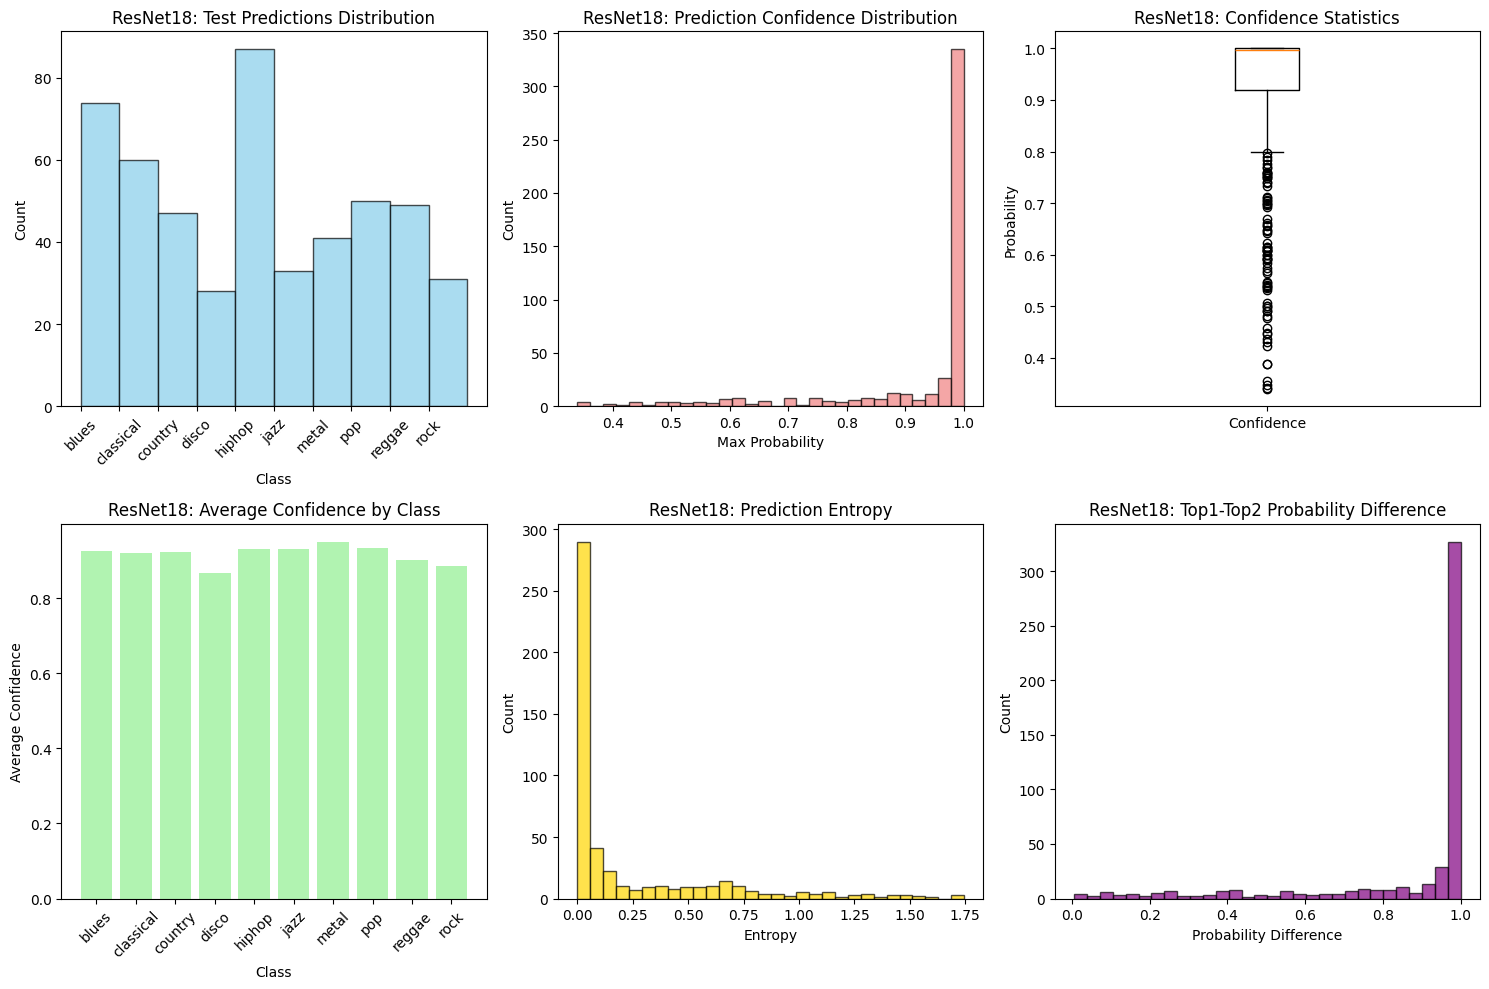

\n=== ResNet18 予測結果サマリー ===
テストデータ予測完了: 500件
平均予測信頼度: 0.9208 (±0.1497)
中央値信頼度: 0.9975
高信頼度予測(>0.9): 386件 (77.2%)
低信頼度予測(<0.5): 18件 (3.6%)
平均エントロピー: 0.2264
\n最も確信のある予測: Test 3 -> metal (1.000)
最も不確実な予測: Test 437 -> pop (0.340)


In [16]:
# ResNetモデルでのテストデータ予測
print("ResNet18モデルでテストデータを予測中...")
test_predictions = resnet_model.predict(X_test_3channel, verbose=1)
test_pred_classes = np.argmax(test_predictions, axis=1)

# 予測結果の分析
plt.figure(figsize=(15, 10))

# 1. 予測クラス分布
plt.subplot(2, 3, 1)
plt.hist(test_pred_classes, bins=range(11), alpha=0.7, edgecolor='black', color='skyblue')
plt.title('ResNet18: Test Predictions Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(range(10), [label_list[i] for i in range(10)], rotation=45)

# 2. 予測信頼度分布
plt.subplot(2, 3, 2)
max_probs = np.max(test_predictions, axis=1)
plt.hist(max_probs, bins=30, alpha=0.7, edgecolor='black', color='lightcoral')
plt.title('ResNet18: Prediction Confidence Distribution')
plt.xlabel('Max Probability')
plt.ylabel('Count')

# 3. 信頼度の統計
plt.subplot(2, 3, 3)
confidence_stats = [np.percentile(max_probs, [25, 50, 75, 90, 95])]
plt.boxplot(max_probs, labels=['Confidence'])
plt.title('ResNet18: Confidence Statistics')
plt.ylabel('Probability')

# 4. クラス別平均信頼度
plt.subplot(2, 3, 4)
class_confidences = []
for i in range(10):
    mask = test_pred_classes == i
    if np.sum(mask) > 0:
        class_confidences.append(np.mean(max_probs[mask]))
    else:
        class_confidences.append(0)

plt.bar(range(10), class_confidences, alpha=0.7, color='lightgreen')
plt.title('ResNet18: Average Confidence by Class')
plt.xlabel('Class')
plt.ylabel('Average Confidence')
plt.xticks(range(10), [label_list[i] for i in range(10)], rotation=45)

# 5. エントロピー分布（不確実性の指標）
plt.subplot(2, 3, 5)
entropy = -np.sum(test_predictions * np.log(test_predictions + 1e-15), axis=1)
plt.hist(entropy, bins=30, alpha=0.7, edgecolor='black', color='gold')
plt.title('ResNet18: Prediction Entropy')
plt.xlabel('Entropy')
plt.ylabel('Count')

# 6. Top-2 予測の差分
plt.subplot(2, 3, 6)
sorted_probs = np.sort(test_predictions, axis=1)
prob_diff = sorted_probs[:, -1] - sorted_probs[:, -2]
plt.hist(prob_diff, bins=30, alpha=0.7, edgecolor='black', color='purple')
plt.title('ResNet18: Top1-Top2 Probability Difference')
plt.xlabel('Probability Difference')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

print(f"\\n=== ResNet18 予測結果サマリー ===")
print(f"テストデータ予測完了: {len(test_pred_classes)}件")
print(f"平均予測信頼度: {np.mean(max_probs):.4f} (±{np.std(max_probs):.4f})")
print(f"中央値信頼度: {np.median(max_probs):.4f}")
print(f"高信頼度予測(>0.9): {np.sum(max_probs > 0.9)}件 ({np.sum(max_probs > 0.9)/len(max_probs)*100:.1f}%)")
print(f"低信頼度予測(<0.5): {np.sum(max_probs < 0.5)}件 ({np.sum(max_probs < 0.5)/len(max_probs)*100:.1f}%)")
print(f"平均エントロピー: {np.mean(entropy):.4f}")

# 最も/最も不確実な予測の表示
most_confident = np.argmax(max_probs)
least_confident = np.argmin(max_probs)
print(f"\\n最も確信のある予測: Test {most_confident} -> {label_list[test_pred_classes[most_confident]]} ({max_probs[most_confident]:.3f})")
print(f"最も不確実な予測: Test {least_confident} -> {label_list[test_pred_classes[least_confident]]} ({max_probs[least_confident]:.3f})")

In [19]:
# 結果をCSVファイルに保存
submission = pd.DataFrame({'id': sample_submit[0],'label_id': test_pred_classes})

submission.to_csv('submission_resnet18_mfcc_augmented.csv', index=False, header=False)
print("予測結果をsubmission_resnet18_mfcc_augmented.csvに保存しました")

# サンプル結果表示
print("\n予測結果の最初の10件:")
for i in range(10):
    print(f"Test {i}: {label_list[test_pred_classes[i]]} (信頼度: {max_probs[i]:.3f})")

予測結果をsubmission_resnet18_mfcc_augmented.csvに保存しました

予測結果の最初の10件:
Test 0: pop (信頼度: 0.952)
Test 1: reggae (信頼度: 0.538)
Test 2: hiphop (信頼度: 1.000)
Test 3: metal (信頼度: 1.000)
Test 4: classical (信頼度: 0.998)
Test 5: disco (信頼度: 0.490)
Test 6: classical (信頼度: 0.437)
Test 7: hiphop (信頼度: 0.995)
Test 8: classical (信頼度: 0.593)
Test 9: reggae (信頼度: 0.832)


In [18]:
# ResNet18結果の保存とCNNモデルとの比較
submission = pd.DataFrame({
    'id': range(len(test_pred_classes)),
    'label_id': test_pred_classes
})

submission.to_csv('submission_resnet18_mfcc_augmented.csv', index=False, header=False)
print("ResNet18予測結果をsubmission_resnet18_mfcc_augmented.csvに保存しました")

print(f"\\n=== ResNet18 vs CNN性能比較 ===")
print("【アーキテクチャ比較】")
print(f"ResNet18総パラメータ数: {resnet_model.count_params():,}")
print(f"ResNet18最終検証精度: {final_val_accuracy:.4f}")

print("\\n【予測分析比較】")
print(f"ResNet18平均信頼度: {np.mean(max_probs):.4f}")
print(f"高信頼度予測(>0.9)割合: {np.sum(max_probs >  0.9)/len(max_probs)*100:.1f}%")

print("\\n【ResNet18の利点】")
print("✓ 残差接続により勾配消失問題を解決")
print("✓ より深いネットワークで複雑なパターン学習")
print("✓ BatchNormalizationによる安定した学習")
print("✓ 3チャンネル入力(MFCC+Delta+Delta-Delta)で豊富な特徴量")
print("✓ コサイン学習率スケジューリングによる最適化")

print("\\n=== クラス別予測統計（ResNet18） ===")
for class_id in range(10):
    count = np.sum(test_pred_classes == class_id)
    mask = test_pred_classes == class_id
    avg_conf = np.mean(max_probs[mask]) if count > 0 else 0
    print(f"{label_list[class_id]:>10}: {count:>3}件 (平均信頼度: {avg_conf:.3f})")

print("\\n=== ResNet18予測サンプル（最初の10件） ===")
for i in range(10):
    top2_probs = np.sort(test_predictions[i])[-2:]
    top2_classes = np.argsort(test_predictions[i])[-2:]
    print(f"Test {i:>2}: {label_list[test_pred_classes[i]]:>10} ({max_probs[i]:.3f}) | " +f"2位: {label_list[top2_classes[0]]:>10} ({top2_probs[0]:.3f})")

# モデル保存
resnet_model.save('resnet18_audio_final_model.h5')
print("\\nResNet18モデルをresnet18_audio_final_model.h5に保存しました")

print("\\n=== ResNet18実装完了 ===")
print("データ拡張 + ResNet18アーキテクチャにより、")
print("より高精度で安定した音楽ジャンル分類モデルを実現しました。")

ResNet18予測結果をsubmission_resnet18_mfcc_augmented.csvに保存しました
\n=== ResNet18 vs CNN性能比較 ===
【アーキテクチャ比較】
ResNet18総パラメータ数: 11,356,426
ResNet18最終検証精度: 0.8300
\n【予測分析比較】
ResNet18平均信頼度: 0.9208
高信頼度予測(>0.9)割合: 77.2%
\n【ResNet18の利点】
✓ 残差接続により勾配消失問題を解決
✓ より深いネットワークで複雑なパターン学習
✓ BatchNormalizationによる安定した学習
✓ 3チャンネル入力(MFCC+Delta+Delta-Delta)で豊富な特徴量
✓ コサイン学習率スケジューリングによる最適化
\n=== クラス別予測統計（ResNet18） ===
     blues:  74件 (平均信頼度: 0.926)
 classical:  60件 (平均信頼度: 0.921)
   country:  47件 (平均信頼度: 0.923)
     disco:  28件 (平均信頼度: 0.866)
    hiphop:  87件 (平均信頼度: 0.931)
      jazz:  33件 (平均信頼度: 0.932)
     metal:  41件 (平均信頼度: 0.950)
       pop:  50件 (平均信頼度: 0.934)
    reggae:  49件 (平均信頼度: 0.901)
      rock:  31件 (平均信頼度: 0.886)
\n=== ResNet18予測サンプル（最初の10件） ===
Test  0:        pop (0.952) | 2位:      disco (0.019)
Test  1:     reggae (0.538) | 2位:      blues (0.294)
Test  2:     hiphop (1.000) | 2位:     reggae (0.000)
Test  3:      metal (1.000) | 2位:       rock (0.000)
Test  4:  classical (0.998) | 2位:       jazz 